In [1]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)

In [3]:
"""init filter wheels to empty pos"""
# init filter wheels
def init_wheels(print_stuff=False):
    if print_stuff: print("Finding filter wheel devices...")
    devices = list_devices()
    if not devices:
        print("No filter wheel devices found.")
        sys.exit(1)
    if print_stuff:
        print("Found devices:")
        for idx, dev in enumerate(devices):
            print(f" [{idx}] {dev}")

    # init filter wheels to empty pos
    for i in range(len(devices)):
        handle = open_device(devices[i])
        max_pos = get_position_count(handle)
        print(max_pos)
        if max_pos > 1:
            set_position(handle, 1)
            if max_pos == 6:
                wheel6_port = i
                handle_6 = handle
            elif max_pos == 12:
                wheel12_port = i
                handle_12 = handle
        else:
            close_device(handle)

    # return handle_6, handle_12, wheel6_port, wheel12_port
    return handle_6

def close_wheels():
    devices = list_devices()
    for i in range(len(devices)):
        handle = open_device(devices[i])
        close_device(handle)

In [4]:
init_wheels(print_stuff=True)
close_wheels()

Finding filter wheel devices...
Found devices:
 [0] COM5
 [1] COM7
 [2] COM4
-1
6
12


In [2]:
"""init camera"""
camera_init()

You selected: ASCOM.ASICamera2.Camera


KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
relative std: 2.7755384186424552e-11


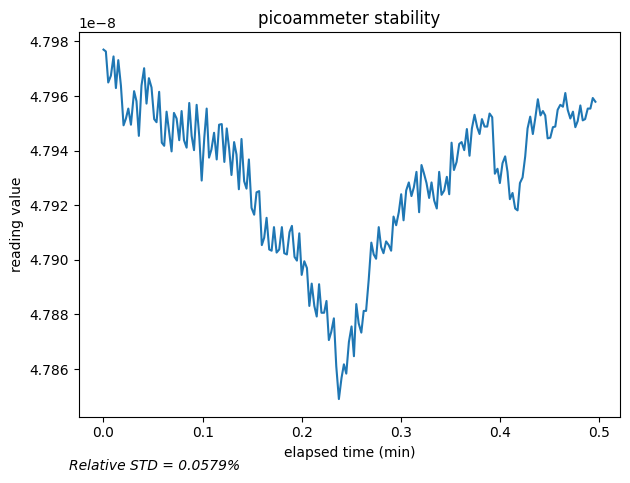

In [18]:
""" picoammeter stability """
def picoam_stability(read_time = 1, save = False):
    # Open serial connection
    ser = serial.Serial(
        port='COM5',         # Replace with your actual port
        baudrate=9600,
        bytesize=serial.EIGHTBITS,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        timeout=2,
        xonxoff=False,
        rtscts=False,
        dsrdtr=False
    )

    init_cmds(ser)

    sample_interval = 0.004          # seconds between reads
    start_time = time.time()
    end_time   = start_time + read_time * 60
    readings_1 = []
    times_1    = []
    while time.time() < end_time:
        time.sleep(sample_interval)
        current = query(ser, 'READ?')
        readings_1.append(current)
        times_1.append(time.time())

    # Convert to NumPy arrays
    readings = np.array(readings_1, dtype=float)
    times    = np.array(times_1,    dtype=float)

    mean_readings = np.mean(readings)
    std_readings = np.std(readings)
    rel_std = std_readings/mean_readings
    print(f"relative std: {std_readings}")

    elapsed = (times - times[0])/60.0
    plt.plot(elapsed, readings)
    plt.xlabel("elapsed time (min)")
    plt.ylabel("reading value")
    plt.title("picoammeter stability")
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.25, 0.01,
                f"Relative STD = {rel_std:.4%}",
                ha="center", fontsize=10, fontstyle='italic')
    plt.tight_layout()
    plt.show()

    if save:
        import pandas as pd
        df = pd.DataFrame({
            'time_min':       elapsed,
            'reading':        readings,
            'relative_std':   rel_std          # single value repeated
        })
        csv_path = f'picoam_readings_{read_time}_min.csv'
        df.to_csv(csv_path, index=False)
        print("saved to path")

    ser.close()

In [ ]:
picoam_stability(read_time = .5, save = False)

In [69]:
"""var exposure capture functions"""
def picoam_worker(ser, stop_event, readings_list, times_list, sample_interval=0.004):
    """
    Continuously query the picoammeter until stop_event is set.
    Appends readings and timestamps into the provided lists.
    """
    while not stop_event.is_set():
        time.sleep(sample_interval)
        raw = query(ser, 'READ?')
        current = float(raw)
        readings_list.append(current)
        times_list.append(time.time())

    ser.close()

def camera_with_picoam(ser, cam_name, exp_low, exp_high, num_exp=10, num_frames=1, img_shape=(1000,1000),
              save_path=None, bit_depth=16, temp_setpoint=None):
    # camera_init()
    # runs take_ramp but records with picoammeter simultaneously
    stop_evt      = threading.Event()
    picoam_readings = []   # plain Python lists so we can append indefinitely
    picoam_times    = []

    picoam_thread = threading.Thread(
        target=picoam_worker,
        args=(ser, stop_evt, picoam_readings, picoam_times),
    )
    picoam_thread.start() # start collecting data with picoammeter

    exp_times, img_array, img_times = take_ramp(cam_name, exp_low, exp_high, num_exp, num_frames, img_shape, save_path, bit_depth, temp_setpoint)

    stop_evt.set() # end picoammeter
    picoam_thread.join()
    picoam_readings = np.array(picoam_readings)
    picoam_times = np.array(picoam_times)
    matched_readings = np.interp(img_times, picoam_times, picoam_readings)
    exp_flat = np.repeat(exp_times, num_frames)
    return exp_flat, matched_readings, img_array, exp_times

def collect_var_exp(cam_name="no_name_given", com_port = 'COM5', bit_depth=16, num_exp=10, num_frames=5,exp_low = 0.00025, exp_high = 0.5, save=False):
    # Open serial connection
    ser = serial.Serial(
        port=com_port,         # Replace with your actual port
        baudrate=9600,
        bytesize=serial.EIGHTBITS,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        timeout=2,
        xonxoff=False,
        rtscts=False,
        dsrdtr=False
    )
    # init picoammeter
    init_cmds(ser)

    exp_flat, matched_readings, exp_img_array, exp_times = camera_with_picoam(
            ser = ser,
            cam_name = cam_name,
            exp_low = exp_low,
            exp_high = exp_high,
            num_exp= num_exp,
            num_frames= num_frames,
            img_shape= (1000,1000),
            save_path= "C:/Users/Jonah/fits_imgs",
            bit_depth=bit_depth
        )

    # # for your ramp test:
    # I_flat = matched_readings  # length num_exp * num_frames
    # I_per_exp = I_flat.reshape(num_exp, num_frames).mean(axis=1)
    # Q_ramp    = I_per_exp * exp_times    # exp_times in seconds

    I_flat = np.array(matched_readings).reshape(-1, num_frames).mean(axis=1)   # A
    Q_ramp = I_flat * exp_times

    # Compute per‐frame signal matrix of shape (num_exp, num_frames) directly from the 4D img_array
    per_frame = exp_img_array.mean(axis=(2,3))   # shape → (num_exp, num_frames)

    # Compute mean ± 1σ across the num_frames for each exposure
    mean_signal = per_frame.mean(axis=1)     # shape → (num_exp,)
    std_signal  = per_frame.std(axis=1)      # shape → (num_exp,)

    exp_ms = exp_times * 1e3
    bit_max = 2**bit_depth - 1
    threshold = 0.5 * bit_max
    exp_50 = np.interp(threshold, mean_signal, exp_ms)

    if save:
        # for saving data
        df = pd.DataFrame({
            'exposure_ms':  exp_ms,
            'mean_ADU':     mean_signal,
            'std_ADU':      std_signal
        })
        path_base = f"exp_{exp_low}-{exp_high}_linearity"
        csv_path = path_base+"_data.csv"
        df.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")

    return I_flat, I_per_exp, Q_ramp, mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, exp_50

def var_exp_graphs(mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, save=False, e_per_adu = None):
    # Prepare your x‐axis: exposure time in ms
    exp_ms = exp_times * 1e3

    # Identify the linear regime
    bit_max = 2**bit_depth - 1

    min_percent = 0.05
    max_percent = 0.95
    # indices of exposures that are within min% and max% of full‐well
    low_idx_arr = np.where(mean_signal >= min_percent * bit_max)[0]
    high_idx_arr = np.where(mean_signal >= max_percent * bit_max)[0]
    if low_idx_arr.size == 0 or high_idx_arr.size == 0:
        raise RuntimeError(f"Your data never reaches {min_percent*100:.0f}% or {max_percent*100:.0f}% of full well!")
    low_idx = low_idx_arr[0]
    high_idx = high_idx_arr[0]

    threshold = 0.5 * bit_max
    exp_50 = np.interp(threshold, mean_signal, exp_ms)
    print(f"Exposure for 50% saturation: {exp_50:.3f} ms")


    # for making graphs
    x_percent = exp_ms[low_idx]
    m, b = np.polyfit(
        exp_ms[low_idx : high_idx + 1],
        mean_signal[low_idx : high_idx + 1],
        1
    )
    """
    # for finding % change in exp time between readings
    delta_exp_ms    = np.diff(exp_ms)           # length num_exp-1
    delta_signal    = np.diff(mean_signal)      # length num_exp-1

    # 2) Relative (percent) change in signal
    percent_change  = delta_signal / mean_signal[:-1] * 100

    # 3) Mid‐points for plotting
    exp_mid_ms      = (exp_ms[:-1] + exp_ms[1:]) / 2
    plt.figure()
    plt.plot(exp_mid_ms, percent_change, 'o-')
    plt.xscale('log')
    plt.xlabel('Exposure (ms) [mid‐point]')
    plt.ylabel('Percent Δ signal (%)')
    plt.title('Percent Change in Signal Between Exposures')
    plt.grid(True, ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    # left: full range
    ax1.errorbar(exp_ms, mean_signal, yerr=std_signal,
                 fmt='o', capsize=3, label='Measured')
    # plot fit line over linear regime
    x_lin = np.linspace(exp_ms[0], exp_ms[high_idx], 200)
    ax1.plot(x_lin, m*x_lin + b, 'r--', label=f'Linear fit: y={m:.3f}*x+{b:.1f}(ADU)')
    # ideal line
    ax1.plot(x_lin, m*x_lin, 'b-.', label=f'Ideal: y={m:.3f}*x')
    # markers
    ax1.axhline(bit_max,     ls=':', color='gray')
    ax1.text(0.99, bit_max, 'Saturation', ha='right', va='bottom', transform=ax1.get_yaxis_transform())
    ax1.axvline(x_percent,         ls=':', color='gray')
    ax1.text(x_percent, 0.01, f'{min_percent*100:.0f}%', va='bottom', ha='center', transform=ax1.get_xaxis_transform())
    ax1.axvline(exp_ms[high_idx], ls=':', color='gray')
    ax1.text(exp_ms[high_idx], 0.01, f'{max_percent*100:.0f}%', va='bottom', ha='center', transform=ax1.get_xaxis_transform())
    # ax1.set_xscale('log')
    ax1.set_xlabel('Exposure (ms)')
    ax1.set_ylabel('Mean signal (ADU)')
    ax1.set_title('a) Full Response')
    ax1.legend(fontsize='small')
    ax4 = ax1.twinx()
    low, high = ax1.get_ylim()
    ax4.set_ylim(low*e_per_adu, high*e_per_adu)
    ax4.set_ylabel('Mean signal (e-)')

    """
    # for zoom in on 0–x_percent
    mask_percent = exp_ms <= x_percent
    ax3.errorbar(exp_ms[mask_percent], mean_signal[mask_percent],
                 yerr=std_signal[mask_percent],
                 fmt='o', capsize=3)
    # show the linear‐fit there too (through origin)
    x_zoom = np.linspace(0, x_percent, 100)
    ax3.plot(x_zoom, m*x_zoom + b, 'r--')
    ax3.plot(x_zoom, m*x_zoom, 'b-.')
    ax3.set_xlim(0, x_percent*1.05)  # a bit of padding
    ax3.set_xscale('linear')
    ax3.set_yscale('linear')
    ax3.set_xlabel('Exposure (ms)')
    ax3.set_title(f'b) 0-{min_percent*100:.0f}% Region')
    ax6 = ax3.twinx()
    low, high = ax3.get_ylim()
    ax6.set_ylim(low*e_per_adu, high*e_per_adu)
    ax6.set_ylabel('Mean signal (e-)')
    ax6.set_yscale('linear')
    """

    # left: full range
    ax2.errorbar(exp_ms, mean_signal, yerr=std_signal,
                 fmt='o', capsize=3, label='Measured')
    # plot fit line over linear regime
    x_lin = np.linspace(exp_ms[0], exp_ms[high_idx], 200)
    ax2.plot(x_lin, m*x_lin + b, 'r--', label=f'Linear fit: y={m:.3f}*x+{b:.1f}(ADU)')
    # ideal line
    ax2.plot(x_lin, m*x_lin, 'b-.', label=f'Ideal: y={m:.3f}*x')
    # markers
    ax2.axhline(bit_max,     ls=':', color='gray')
    ax2.text(0.99, bit_max, 'Saturation', ha='right', va='bottom', transform=ax2.get_yaxis_transform())
    ax2.axvline(x_percent,         ls=':', color='gray')
    ax2.text(x_percent, 0.01, f'{min_percent*100:.0f}%', va='bottom', ha='center', transform=ax2.get_xaxis_transform())
    ax2.axvline(exp_ms[high_idx], ls=':', color='gray')
    ax2.text(exp_ms[high_idx], 0.01, f'{max_percent*100:.0f}%', va='bottom', ha='center', transform=ax2.get_xaxis_transform())
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Exposure (ms)')
    ax2.set_ylabel('Mean signal (ADU)')
    ax2.set_title('b) Full Response, log scale')
    ax5 = ax2.twinx()
    low, high = ax2.get_ylim()
    ax5.set_ylim(low*e_per_adu, high*e_per_adu)
    ax5.set_ylabel('Mean signal (e-)')
    ax5.set_yscale('log')

    ax2.grid(True, ls='--', lw=0.5)
    ax1.grid(True, ls='--', lw=0.5)
    # ax3.grid(True, ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()

    if save:
        path_base = f"exp_{exp_low}-{exp_high}_linearity"
        fig_path = path_base+"_figure.png"
        fig.savefig(fig_path, dpi=300)
        print(f"Figure saved to {fig_path}")

KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
Camera connected: ASCOM.ASICamera2.Camera, Size: 6248x4176, Temperature: 0.00C
camera offset: 0
Taking frames at 0.00025000 seconds (exposure time 1/50)
Taking frames at 0.00029195 seconds (exposure time 2/50)
Taking frames at 0.00034094 seconds (exposure time 3/50)
Taking frames at 0.00039815 seconds (exposure time 4/50)
Taking frames at 0.00046496 seconds (exposure time 5/50)
Taking frames at 0.00054297 seconds (exposure time 6/50)
Taking frames at 0.00063409 seconds (exposure time 7/50)
Taking frames at 0.00074048 seconds (exposure time 8/50)
Taking frames at 0.00086474 seconds (exposure time 9/50)
Taking frames at 0.00100984 seconds (exposure time 10/50)
Taking frames at 0.00117929 seconds (exposure time 11/50)
Taking frames at 0.00137717 seconds (exposure time 12/50)
Taking frames at 0.00160826 seconds (exposure time 13/50)
Taking frames at 0.00187812 seconds (exposure time 14/50)
Taking frames at 0.00

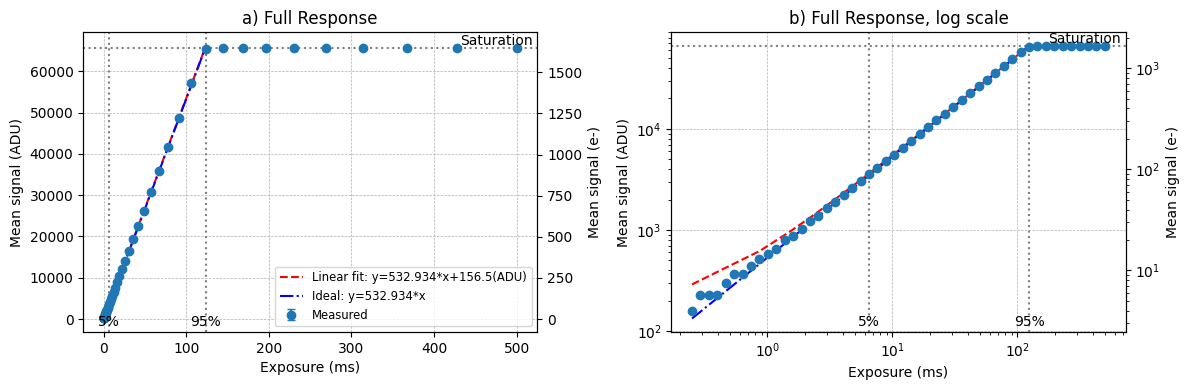

Figure saved to exp_0.00025-0.5_linearity_figure.png


In [70]:
"""Compares camera data vs picoammeter data, var exposure"""
I_flat, I_per_exp, Q_ramp, mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, exp_50 = (
    collect_var_exp(cam_name="ASCOM.ASICamera2.Camera", num_exp=50, num_frames=10, exp_low = 0.00025, exp_high = 0.5, save=True)
)

var_exp_graphs(mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, save=True, e_per_adu=e_per_adu)

In [66]:
"""Gain calculator"""
def capture_frame(camera, exposure_ms, is_dark=False):
    """
    Capture a single frame:
     - is_dark=False → Light frame (flat)
     - is_dark=True  → Dark frame
    """
    # ASCOM expects seconds, not ms
    exposure_s = exposure_ms / 1000.0
    # LightFrame=True for a flat, False for a dark
    light = not is_dark
    camera.StartExposure(exposure_s, light)

    while not camera.ImageReady:
        time.sleep(0.01)
    return np.array(camera.ImageArray, dtype=float)

# --- Gain calculation via flat/dark method ---
def calculate_gain(camera, exposure_ms, n_frames=10, print_stuff=False):
    if print_stuff: print("starting calculation")
    """
    Calculate e-/ADU gain using flat and dark frames.

    Steps:
    1. Capture n flat frames under uniform illumination.
    2. Capture n dark frames with shutter closed.
    3. Compute mean and variance of flats and darks.
    4. Gain = (mean_flat - mean_dark) / (var_flat - var_dark)

    Returns:
    - gain_e_per_adu: measured gain in electrons per ADU
    - stats: dict with means and variances
    """
    # Capture flats
    flats = [capture_frame(camera, exposure_ms, is_dark=False)
         for _ in range(n_frames)]
    flats = np.stack(flats)
    if print_stuff: print("flats collected")
    # Capture darks
    cmd = 'n'
    while cmd != 'y':
        cmd = input("Did you CLOSE the shutter? (y/n)").strip().lower()
    time.sleep(10)
    darks = [capture_frame(camera, exposure_ms, is_dark=True)
         for _ in range(n_frames)]
    darks = np.stack(darks)
    if print_stuff: print("darks collected")
    cmd = 'n'
    while cmd != 'y':
        cmd = input("Did you OPEN the shutter? (y/n)").strip().lower()
    # Compute statistics
    mean_flat = np.mean(flats)
    var_flat = np.var(flats, ddof=1)
    mean_dark = np.mean(darks)
    var_dark = np.var(darks, ddof=1)
    # Avoid division by zero
    diff_var = var_flat - var_dark
    if diff_var <= 0:
        raise ValueError("Variance difference flat-dark must be positive")

    # Calculate gain
    gain_e_per_adu = (mean_flat - mean_dark) / diff_var
    stats = {
        'mean_flat': mean_flat,
        'var_flat': var_flat,
        'mean_dark': mean_dark,
        'var_dark': var_dark
    }
    return gain_e_per_adu, stats

def get_gain(cam_name="no_name_given", num_frames = 5, print_stuff=False):
    camera_init()
    camera = win32com.client.Dispatch(cam_name)
    camera.Connected = True
    # Exposure for calibration (ms)
    exposure_time = .25

    # Calculate gain
    gain, stats = calculate_gain(camera, exposure_time, num_frames)
    if print_stuff:
        print(f"Measured: {gain:.5f} e-/ADU on mode={camera.Gain} gain")
        print(f"Flat mean: {stats['mean_flat']}, Flat var: {stats['var_flat']:.1f}")
        print(f"Dark mean: {stats['mean_dark']:}, Dark var: {stats['var_dark']:.1f}")

    camera.Connected = False
    return gain


"""
results
High gain = .024 e-/ADU
Middle gain = .245 e-/ADU
Low gain = .739 e-/ADU
"""

'\nresults\nHigh gain = .024 e-/ADU\nMiddle gain = .245 e-/ADU\nLow gain = .739 e-/ADU\n'

In [67]:
e_per_adu = get_gain(cam_name="ASCOM.ASICamera2.Camera", num_frames=2, print_stuff=True)

You selected: ASCOM.ASICamera2.Camera
Measured: 0.02511 e-/ADU on mode=300 gain
Flat mean: 655.4876299113034, Flat var: 9641.8
Dark mean: 503.67196025716737, Dark var: 3595.9


In [74]:
"""fixed exposure var filters"""
# --- Picoammeter worker ---
def picoam_worker(ser, stop_event, readings_list, times_list, sample_interval=0.004):
    while not stop_event.is_set():
        time.sleep(sample_interval)
        raw = query(ser, 'READ?')
        readings_list.append(float(raw))
        times_list.append(time.time())
    ser.close()

# --- Capture fixed-exposure frames with filter changes ---
def camera_with_filters(
    cam_name,
    exposure_s,
    num_filters,
    frames_per_filter,
    nd_positions,
    handle,
    filter_change=True,
    ser=None,
    save_path=None,
    bit_depth=16,
    target_shape=(1000,1000),
    filters = []
):
    # Start picoammeter thread
    stop_evt = threading.Event()
    pico_readings, pico_times = [], []
    pico_thread = threading.Thread(
        target=picoam_worker,
        args=(ser, stop_evt, pico_readings, pico_times)
    )
    pico_thread.start()

# Prepare camera
    camera = win32com.client.Dispatch(cam_name)
    camera.Connected = True
    # Set ROI for target_shape
    cam_w = camera.CameraXSize
    cam_h = camera.CameraYSize
    tx, ty = target_shape[1], target_shape[0]
    sx = (cam_w - tx) // 2
    sy = (cam_h - ty) // 2
    camera.NumX = tx
    camera.NumY = ty
    camera.StartX = sx
    camera.StartY = sy
    camera.Offset = 0
    camera.BinX = camera.BinY = 1

    # Pre-allocate arrays
    filter_img_array = np.zeros((num_filters, frames_per_filter, ty, tx), dtype=np.uint16)
    filter_img_times = np.zeros((num_filters, frames_per_filter))
    exp_flat = np.full(num_filters * frames_per_filter, exposure_s)

    for i, pos in enumerate(nd_positions):
        print(f"starting filter {pos}")
        # Move to filter position
        set_position(handle, i+1)
        time.sleep(0.5)
        for j in range(frames_per_filter):
            camera.StartExposure(exposure_s, False)
            while not camera.ImageReady:
                time.sleep(0.01)
            filter_img = np.array(camera.ImageArray, dtype=float)
            # Crop if needed
            h, w = filter_img.shape
            if (h, w) != target_shape:
                crop_sy = (h - ty) // 2
                crop_sx = (w - tx) // 2
                filter_img = filter_img[crop_sy:crop_sy+ty, crop_sx:crop_sx+tx]
            filter_img_array[i, j] = filter_img.astype(np.uint16)
            filter_img_times[i, j] = time.time()


        # After capturing all frames for this filter, save a FITS cube
        if save_path:
            data_cube = filter_img_array[i]  # shape (frames_per_filter, ty, tx)
            hdu = fits.PrimaryHDU(data_cube)
            hdr = hdu.header
            hdr['DATE'] = time.strftime('%Y-%m-%dT%H:%M:%S', time.gmtime())
            hdr.comments['DATE'] = 'File creation date'
            hdr['DATE-OBS'] = time.strftime('%Y-%m-%dT%H:%M:%S', time.gmtime())
            hdr.comments['DATE-OBS'] = 'Date of data acquisition'
            # hdr['EXPTIME'] = camera.LastExposureDuration
            hdr['EXPTIME'] = exposure_s
            hdr.comments['EXPTIME'] = 'Exposure time in s'
            hdr['TEMP'] = camera.CCDTemperature
            hdr.comments['TEMP'] = 'Sensor temperature (in deg C)'
            hdr['MODE'] = camera.ReadoutModes[camera.ReadoutMode]
            hdr['GAIN'] = camera.Gain
            hdr.comments['GAIN'] = 'Camera gain setting if applicable'
            hdr['SENSNAME'] = camera.Name
            hdul = fits.HDUList([hdu])
            fname = f"{save_path}/nd_{filters[i]}_cube.fits"
            hdul.writeto(fname, overwrite=True)


    # Stop picoammeter
    stop_evt.set()
    pico_thread.join()
    set_position(handle, 1)
    # interpolate pico readings at image times
    pico_readings = np.array(pico_readings)
    pico_times    = np.array(pico_times)
    matched_readings = np.interp(filter_img_times.flatten(), pico_times, pico_readings)


    return (
        exp_flat,
        matched_readings,
        filter_img_array,
        filter_img_times.flatten()
    )

def collect_var_filters(save_path, num_frames=5, bit_depth=16, com_port='COM5', cam_name="no_name_given", exp_50=-1):
    handle6 = init_wheels()  # user-defined
    # Serial port for picoammeter
    ser = serial.Serial(com_port, 9600, timeout=2)
    init_cmds(ser)

    nd_positions = [1,2,3,4,5,6]
    filters = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]

    if exp_50==-1:
        raise(ValueError, "exp_50 was not given")
    exp_s = exp_50/1000
    num_filters = len(nd_positions)

    exp_flat, currents, filter_imgs, times = camera_with_filters(
        cam_name,
        exp_s,
        num_filters,
        num_frames,
        nd_positions,
        handle6,
        save_path=save_path,
        bit_depth=bit_depth,
        ser=ser,
        filters = filters
    )
    # I_filt = currents     # length num_filters * frames_per_filter
    # I_per_filt = I_filt.reshape(num_filters, num_frames).mean(axis=1)
    # Q_filt = I_per_filt * exp_s  # exposure_s in seconds

    signals_f = filter_imgs.mean(axis=(2,3)).reshape(len(currents)//num_frames, num_frames).mean(axis=1)
    I_f     = np.array(currents).reshape(len(currents)//num_frames, num_frames).mean(axis=1)
    Q_filt  = I_f * exp_s

    stds_f = filter_imgs.std(axis=(1,2,3))

    if save_path:
        num_filters, num_frames, H, W = filter_imgs.shape

        # flatten currents if not already
        currents_flat = np.array(currents).flatten()

        rows = []
        for i, od in enumerate(filters):
            for j in range(num_frames):
                idx = i * num_frames + j
                img = filter_imgs[i, j]
                mean_adu = img.mean()
                std_adu  = img.std()
                current   = currents_flat[idx]
                Q         = current * exp_s
                rows.append({
                    'filter_OD':    od,
                    'frame_idx':    j,
                    'mean_ADU':     mean_adu,
                    'std_ADU':      std_adu,
                })

        df = pd.DataFrame(rows)

        # make sure output dir exists
        os.makedirs(save_path, exist_ok=True)
        out_csv = os.path.join(save_path, 'filter_frame_data.csv')
        df.to_csv(out_csv, index=False)
        print(f"Wrote per-frame filter data to {out_csv}")
    close_wheels()
    print("finished")

    return I_filt, signals_f, Q_filt


In [75]:
I_filt, signals_f, Q_filt = collect_var_filters(save_path = 'C:/Users/Jonah/fits_imgs', cam_name="ASCOM.ASICamera2.Camera", exp_50=exp_50, num_frames=5)

-1
6
12

starting filter 1
starting filter 2
starting filter 3
starting filter 4
starting filter 5
starting filter 6
Wrote per-frame filter data to C:/Users/Jonah/fits_imgs\filter_frame_data.csv
finished


In [58]:
def compare_exp_and_filter(e_per_adu = None, Q_ramp=None, Q_filt=None, signals_f=None, mean_signal=None, save=False):
    fig, (ax1) = plt.subplots(1, 1, figsize=(8,6))
    ax1.plot(Q_ramp,    mean_signal,  'o-', color='C0', label='var exposure')
    ax1.plot(Q_filt,    signals_f, 's--', color='C1', label='var filters')
    ax1.set_xlabel('Total collected charge $Q=I\\times t$ (A·s)')
    ax1.set_ylabel('Mean signal (ADU)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title('Camera Response vs. Total Illumination')
    ax1.legend()
    ax1.grid(ls='--', lw=0.5)
    ax2 = ax1.twinx()
    low, high = ax1.get_ylim()
    ax2.set_ylim(low*e_per_adu, high*e_per_adu)
    ax2.set_ylabel('Mean signal (e-)')
    ax2.set_yscale('log')
    if save:
        path_base = f"exp_vs_filter"
        fig_path = path_base+"_figure.png"
        fig.savefig(fig_path, dpi=300)
        print(f"Figure saved to {fig_path}")

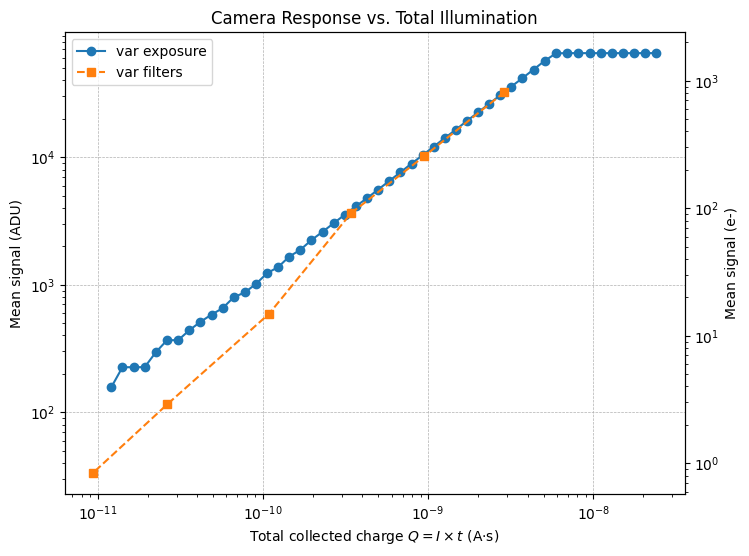

In [71]:
compare_exp_and_filter(e_per_adu = e_per_adu, Q_ramp=Q_ramp, Q_filt=Q_filt, signals_f=signals_f, mean_signal=mean_signal, save=True)